# Basic Style Transfer

#### Author: Kevin Marroquin



In this notebook, I will be going through a very simple and basic style transfer using *Gatys et. al* paper titled [A Neural Algorithm of Artistic Style](https://arxiv.org/pdf/1508.06576.pdf). Uploading a basic premade cnn model (vgg16) and using it to transfer style onto certain images is the goal. With success, exporting the model onto other images could provide interesting results.

NOTE: This notebook was made for tensorflow version 1 and is outdated. Will NOT work with tensorflow 2+. 

## Part 1: Build Model and Define Losses

First we want to initialize a VGG16 model we can use for style transfer.  

In [1]:
from keras.applications import vgg16
from keras.layers import Input, Concatenate, concatenate
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
#Clearing session in case of re-running of cell
K.clear_session()

#Creating layers and intput/output tensors
content_input = Input(batch_shape=(1, 224, 224, 3))
style_input = Input(batch_shape=(1, 224, 224, 3))
output_tensor = tf.get_variable("output_tensor", [1, 224, 224, 3])
output_input = Input(tensor=output_tensor)
input_tensor = concatenate([content_input, style_input, output_input],
                           axis = 1)

In [3]:
#Creating a pretrained VGG 16 model and printing out structure of model
vgg_model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
vgg_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (1, 224, 224, 3)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (1, 224, 224, 3)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (1, 224, 224, 3)     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (1, 672, 224, 3)     0           input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [4]:
#Seeing what types of laters exist in our model
print([layer.name for layer in vgg_model.layers])

['input_1', 'input_2', 'input_3', 'concatenate_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


In [5]:
# now select one of the above listed layers to be the layer to use for content information
# and select some number of layers (maybe 2 or 3 layers) from the above layers to be the
# style information. If you choose layers closer to the input this will use 
# more simplistic features, and choosing layers closer to the end will use more complicated
# abstracted features.
content_layer = 'block5_conv1'
style_layers = [
    'block1_conv1',
    'block2_conv1'
]
# you can also play with the_content and style loss weights if you want to. this will effect 
# how stylized vs similar to the content image the output will look.
content_loss_weight = 255.0
style_loss_weight = 500.0

In [6]:
layers_dict = dict([(layer.name, layer.output) for layer in vgg_model.layers])

### Loss Functions
We want to define our style transfer losses now. First, we are going to define a feature reconstruction loss based on our content features and our output features. Using tensorflow functions implement the following loss function: $$\mathcal{L}_{Feature} = \frac{1}{2} \sum_{i,j, k} (F_{ijk} - P_{ijk})^2$$ where $F$ is the 3D tensor of content features and $P$ is the 3D tensor of our output image features.

In [7]:
def feature_reconstruction_loss(content_img_features, output_img_features):
    """Takes a tensor representing a layer of VGG features from the content image
    and a tensor representing a layer of VGG features from the current output image and returns a loss value.
    """
    return tf.reduce_sum(
            tf.square(content_img_features - output_img_features))/2

Now we wish to define our style loss function. First, we have to take our features and represent them as a Gram Matrix, for more information on Gram Matrices and this loss function you can read the paper if you like. Then we wish to implement the loss function:
$$ \mathcal{L}_{Style} = \frac{1}{4H^2W^2C^2} \sum_{ij} (G_{ij} - A_{ij})^2 $$ where $G$ is the Gram matrix of the output image features and $A$ is the Gram Matrix of the style image features. Note that we have written a Gram matrix function for you so you only need to call it.

In [8]:
def gram_matrix(x):
    # make channels first dimension
    x = tf.transpose(x, (2, 0, 1))
    # flatten everything but channels so x is now (C, H*W)
    x = tf.reshape(x, tf.stack([-1, tf.reduce_prod(tf.shape(x)[1:])]))
    return tf.matmul(x, tf.transpose(x))

In [9]:
def style_loss(style_img_features, output_img_features, img_shape):
    """Takes a tensor representing a layer of VGG features from the style image and a tensor
    representing a layer of VGG features from the current output image and returns 
    the style loss for these features.
    """
    top = tf.reduce_sum(tf.square(
        gram_matrix(output_img_features) - gram_matrix(style_img_features)))
    
    bottom = 4 * img_shape[0]**2 * img_shape[1]**2 *img_shape[2]**2
    
    return top / bottom

In [10]:
content_features = layers_dict[content_layer]
content_img_features = tf.transpose(content_features)[0, :, :, :]
output_content_features = tf.transpose(content_features)[2, :, :, :]
content_loss = feature_reconstruction_loss(
    content_img_features, output_content_features)

In [11]:
total_style_loss = tf.zeros(1)
weight = 1.0 / len(style_layers)
for style_layer in style_layers:
    style_features = layers_dict[style_layer]
    style_img_features = tf.transpose(style_features)[1, :, :, :]
    output_img_features = tf.transpose(style_features)[2, :, :, :]
    total_style_loss += weight * style_loss(style_img_features, output_img_features, (224, 224, 3))

Now we need to combine our two loss functions using the weightings we defined earlier.

In [12]:
total_loss = content_loss_weight * content_loss + \
             style_loss_weight * total_style_loss 

In [13]:
optimize = tf.train.AdamOptimizer(learning_rate=10).minimize(total_loss, var_list=[output_tensor])

## Part 2: Feeding in Images

We now want to load and preprocess our images. keras provides a `load_img` function that conviently loads our image and then cuts it down to our target size. Keras also provides a `vgg16.preprocess_input` that preprocesses images to be in the format vgg16 expects. Use these two functions to write the load_image function below.

In [14]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
def load_image(img_path):
    img = load_img(img_path, target_size = (224, 224, 3))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x):
    x = x.reshape((224, 224, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [15]:
content_img_path = 'images/campanile.jpg'
style_img_path = 'images/monet_style.jpg'

In [16]:
content_img = load_image(content_img_path)
style_img = load_image(style_img_path)

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

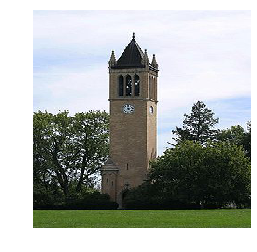

In [18]:
plt.imshow(deprocess_image(content_img))
plt.axis('off')
plt.show()

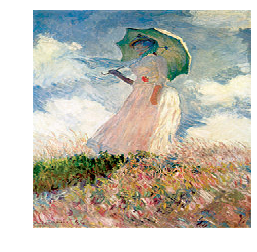

In [19]:
plt.imshow(deprocess_image(style_img))
plt.axis('off')
plt.show()

## Part 3: Stylize Images

In [20]:
#Loading pictures again since deprocess_image affects image output
#Path for images
content_img_path = 'images/campanile.jpg'
style_img_path = 'images/monet_style.jpg'

#Loading images
content_img = load_image(content_img_path)
style_img = load_image(style_img_path)

In [21]:
assign_var = tf.assign(output_tensor, content_img)
sess = K.get_session()
var = sess.run(assign_var)

Running the cell below will update the image 10 times. Since the initialization code is in the cell above, if you run the cell below and you're output isn't great you can run for another 10 iterations simply by rerunning the cell below.

In [22]:
import time
start = time.time()
n_iterations = 10
for i in range(n_iterations):
    print("Running iteration: {}".format(i))
    _, output_val, loss = sess.run([optimize, output_tensor, total_loss], feed_dict={content_input: content_img, style_input: style_img})
print("Total time:", time.time() - start)    

Running iteration: 0
Running iteration: 1
Running iteration: 2
Running iteration: 3
Running iteration: 4
Running iteration: 5
Running iteration: 6
Running iteration: 7
Running iteration: 8
Running iteration: 9
Total time: 65.7445969581604


In [23]:
output_img = deprocess_image(output_val)

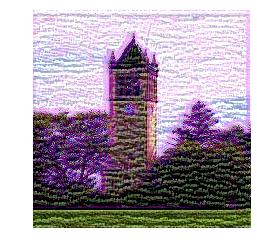

In [24]:
plt.imshow(output_img)
plt.axis('off')
plt.show()

Okay! This is a start. However, we don't necessarily have fine image of this picture. Let's try to automate this and see if we can obtain a finer picture.

## Part 4: Automating to Obtain a More Accurate Picture

We load everything above into once cell, one function. Experimenting through the paper by [Gatys et al.](https://arxiv.org/pdf/1508.06576.pdf) and through trial and error (not entirely shown), we obtain the following style transfer trials

In [133]:
def styleTransfer(content_layer, style_layers, 
                  content_loss_weight, style_loss_weight,
                  content_img_path, style_img_path,
                  show = True):
    """
    Function takes two pictures, one normal picture and anothers whom style
    is extracted and mixed to a normal picture.
    
    Inputs:
        content_layer: A content layer
        style_layer: A list of style layers
        content_loss_weight: Content loss weight value
        style_loss_weight: Style loss weight value
        content_img_path: Image path to get stylized
        style_img_path: Image path to extract style from
        show (optional): Boolean determining whether to show or return output
        
    Returns:
        An image stylized
    
    """
    from keras.applications import vgg16
    from keras.layers import Input, Concatenate, concatenate
    from keras.models import Model, Sequential
    from keras import backend as K
    import tensorflow as tf
    from keras.preprocessing.image import load_img, img_to_array
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline

    #Clearing session in case of re-running of cell
    K.clear_session()

    #Creating layers and intput/output tensors
    content_input = Input(batch_shape=(1, 224, 224, 3))
    style_input = Input(batch_shape=(1, 224, 224, 3))
    output_tensor = tf.get_variable("output_tensor", [1, 224, 224, 3])
    output_input = Input(tensor=output_tensor)
    input_tensor = concatenate([content_input, style_input, output_input],
                               axis = 1)

    #Creating a pretrained VGG 16 model 
    vgg_model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

    #Selecting layers
    content_layer = content_layer
    style_layers = style_layers

    #Selecting loss weights
    content_loss_weight = content_loss_weight
    style_loss_weight = style_loss_weight

    
    #Layers in dictionary form
    layers_dict = dict([(layer.name, layer.output) for layer in vgg_model.layers])

    #Defining loss functions
    def feature_reconstruction_loss(content_img_features, output_img_features):
        """Takes a tensor representing a layer of VGG features from the content image
        and a tensor representing a layer of VGG features from the current output image and returns a loss value.
        """
        return tf.reduce_sum(
                tf.square(content_img_features - output_img_features))/2

    def gram_matrix(x):
        # make channels first dimension
        x = tf.transpose(x, (2, 0, 1))
        # flatten everything but channels so x is now (C, H*W)
        x = tf.reshape(x, tf.stack([-1, tf.reduce_prod(tf.shape(x)[1:])]))
        return tf.matmul(x, tf.transpose(x))


    def style_loss(style_img_features, output_img_features, img_shape):
        """Takes a tensor representing a layer of VGG features from the style image and a tensor
        representing a layer of VGG features from the current output image and returns 
        the style loss for these features.
        """
        top = tf.reduce_sum(tf.square(
            gram_matrix(output_img_features) - gram_matrix(style_img_features)))

        bottom = 4 * img_shape[0]**2 * img_shape[1]**2 *img_shape[2]**2

        return top / bottom


    #Content development and style
    content_features = layers_dict[content_layer]
    content_img_features = tf.transpose(content_features)[0, :, :, :]
    output_content_features = tf.transpose(content_features)[2, :, :, :]
    content_loss = feature_reconstruction_loss(
        content_img_features, output_content_features)


    total_style_loss = tf.zeros(1)
    weight = 1.0 / len(style_layers)
    for style_layer in style_layers:
        style_features = layers_dict[style_layer]
        style_img_features = tf.transpose(style_features)[1, :, :, :]
        output_img_features = tf.transpose(style_features)[2, :, :, :]
        total_style_loss += weight * style_loss(style_img_features, output_img_features, (224, 224, 3))


    #Combining two loss functions based on papers
    total_loss = content_loss_weight * content_loss + style_loss_weight * total_style_loss 
    optimize = tf.train.AdamOptimizer(learning_rate=10).minimize(total_loss, var_list=[output_tensor])


    #Feeding in images
    def load_image(img_path):
        img = load_img(img_path, target_size = (224, 224, 3))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = vgg16.preprocess_input(img)
        return img

    def deprocess_image(x):
        x = x.reshape((224, 224, 3))
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        # 'BGR'->'RGB'
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype('uint8')
        return x


    #Loading path for images
    content_img_path = content_img_path
    style_img_path = style_img_path

    content_img = load_image(content_img_path)
    style_img = load_image(style_img_path)


    #Stylizing images
    assign_var = tf.assign(output_tensor, content_img)
    sess = K.get_session()
    var = sess.run(assign_var)


    #Running output through ten iterations
    import time
    start = time.time()
    n_iterations = 10
    for i in range(n_iterations):
        print("Running iteration: {}".format(i))
        _, output_val, loss = sess.run([optimize, output_tensor, total_loss], feed_dict={content_input: content_img, style_input: style_img})
    print("Total time:", time.time() - start)    


    #Output and displaying/returning image
    output_img = deprocess_image(output_val)
    if show:
        plt.imshow(output_img)
        plt.axis('off')
        plt.show()
    else:
        return output_img

In [134]:
def imageComparison(img1, img2, styled):
    """
    Creates a comparison of images, particularly to see if style transfer is 
    done well.
    
    Arguments:
        img1: Image that shows original, path
        img2: Image that shows style, path
        styled: Image that has styled transfered to original, func
        
    Return:
        Shows a figure containing images to compare listed to compare.


    """
    
    def load_image(img_path):
        img = load_img(img_path, target_size = (224, 224, 3))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = vgg16.preprocess_input(img)
        return img

    def deprocess_image(x):
        x = x.reshape((224, 224, 3))
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        # 'BGR'->'RGB'
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    plt.figure(figsize=(20, 15))
    plt.subplot(131)
    plt.imshow(deprocess_image(load_image(img1)))
    plt.axis("off")
    plt.subplot(132)
    plt.imshow(deprocess_image(load_image(img2)))
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(styled)
    plt.axis("off")
    plt.show()

In [194]:
def multi_imageComparison(img1, img2, *args,  save = False):
    """
    
    Creates a comparison of images, particularly to see how certain style 
    transfer trials faired with each other.
    
    Inputs:
        img1: Image that shows original, path
        img2: Image that shows style, path
        args: Styled images
        
    Return:
        Shows a figure containing images to compare, taking n arguments
    """
    
    def load_image(img_path):
        img = load_img(img_path, target_size = (224, 224, 3))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = vgg16.preprocess_input(img)
        return img

    def deprocess_image(x):
        x = x.reshape((224, 224, 3))
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        # 'BGR'->'RGB'
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    plt.figure(figsize=(20, 20))
    for i, arg in enumerate(args):
        plt.subplot(131 + 100*len(args) + i*3)
        plt.imshow(deprocess_image(load_image(img1)))
        plt.axis("off")
        plt.subplot(132 + 100*len(args) + i*3)
        plt.imshow(deprocess_image(load_image(img2)))
        plt.axis("off")
        plt.subplot(133 + 100*len(args) + i*3)
        plt.imshow(arg)
        plt.axis("off")
    plt.tight_layout()
    if save:
        plt.savefig("Styled Campanile.jpg")
    plt.show()

Running iteration: 0
Running iteration: 1
Running iteration: 2
Running iteration: 3
Running iteration: 4
Running iteration: 5
Running iteration: 6
Running iteration: 7
Running iteration: 8
Running iteration: 9
Total time: 57.24612498283386


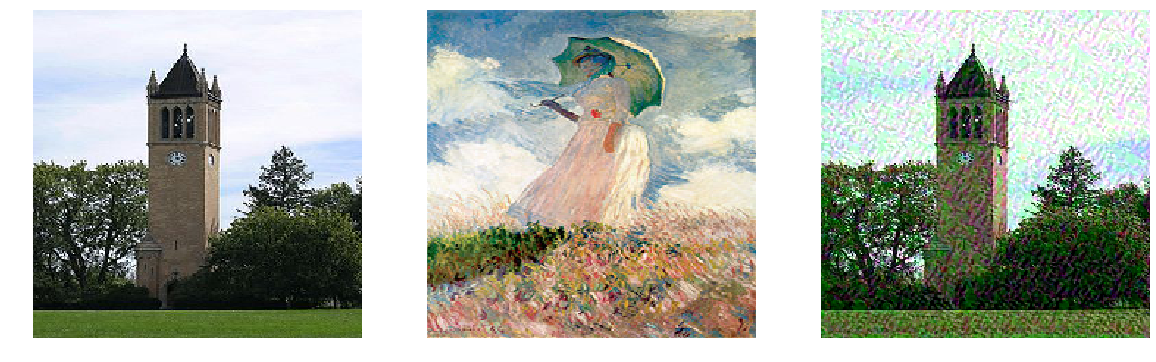

In [130]:
trial0 = styleTransfer('block2_pool', ["block1_conv1", "block2_conv1",
                                    "block3_conv1", "block4_conv1", "block5_conv1"], 2050, 50,
            'images/campanile.jpg', 'images/monet_style.jpg', show = False)
imageComparison('images/campanile.jpg', 'images/monet_style.jpg', trial0)

Running iteration: 0
Running iteration: 1
Running iteration: 2
Running iteration: 3
Running iteration: 4
Running iteration: 5
Running iteration: 6
Running iteration: 7
Running iteration: 8
Running iteration: 9
Total time: 41.71125507354736


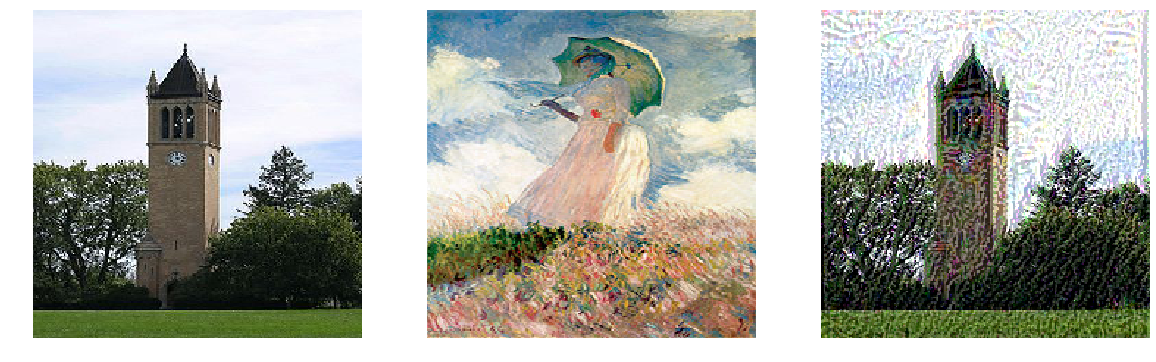

In [131]:
trial1 = styleTransfer('block4_conv3', ['block2_conv2', 'block3_conv2'], 1050, 500,
            'images/campanile.jpg', 'images/monet_style.jpg', show = False)
imageComparison('images/campanile.jpg', 'images/monet_style.jpg', trial1)

Running iteration: 0
Running iteration: 1
Running iteration: 2
Running iteration: 3
Running iteration: 4
Running iteration: 5
Running iteration: 6
Running iteration: 7
Running iteration: 8
Running iteration: 9
Total time: 34.69280791282654


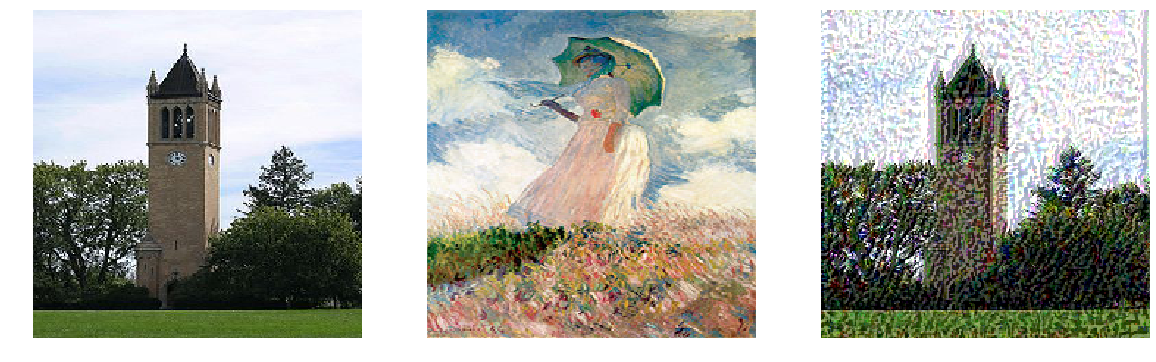

In [132]:
trial2 = styleTransfer('block4_conv1', ['block2_conv2', 'block3_conv2'], 500, 700,
            'images/campanile.jpg', 'images/monet_style.jpg', show = False)
imageComparison('images/campanile.jpg', 'images/monet_style.jpg', trial2)

Putting all of these plots in one figure:

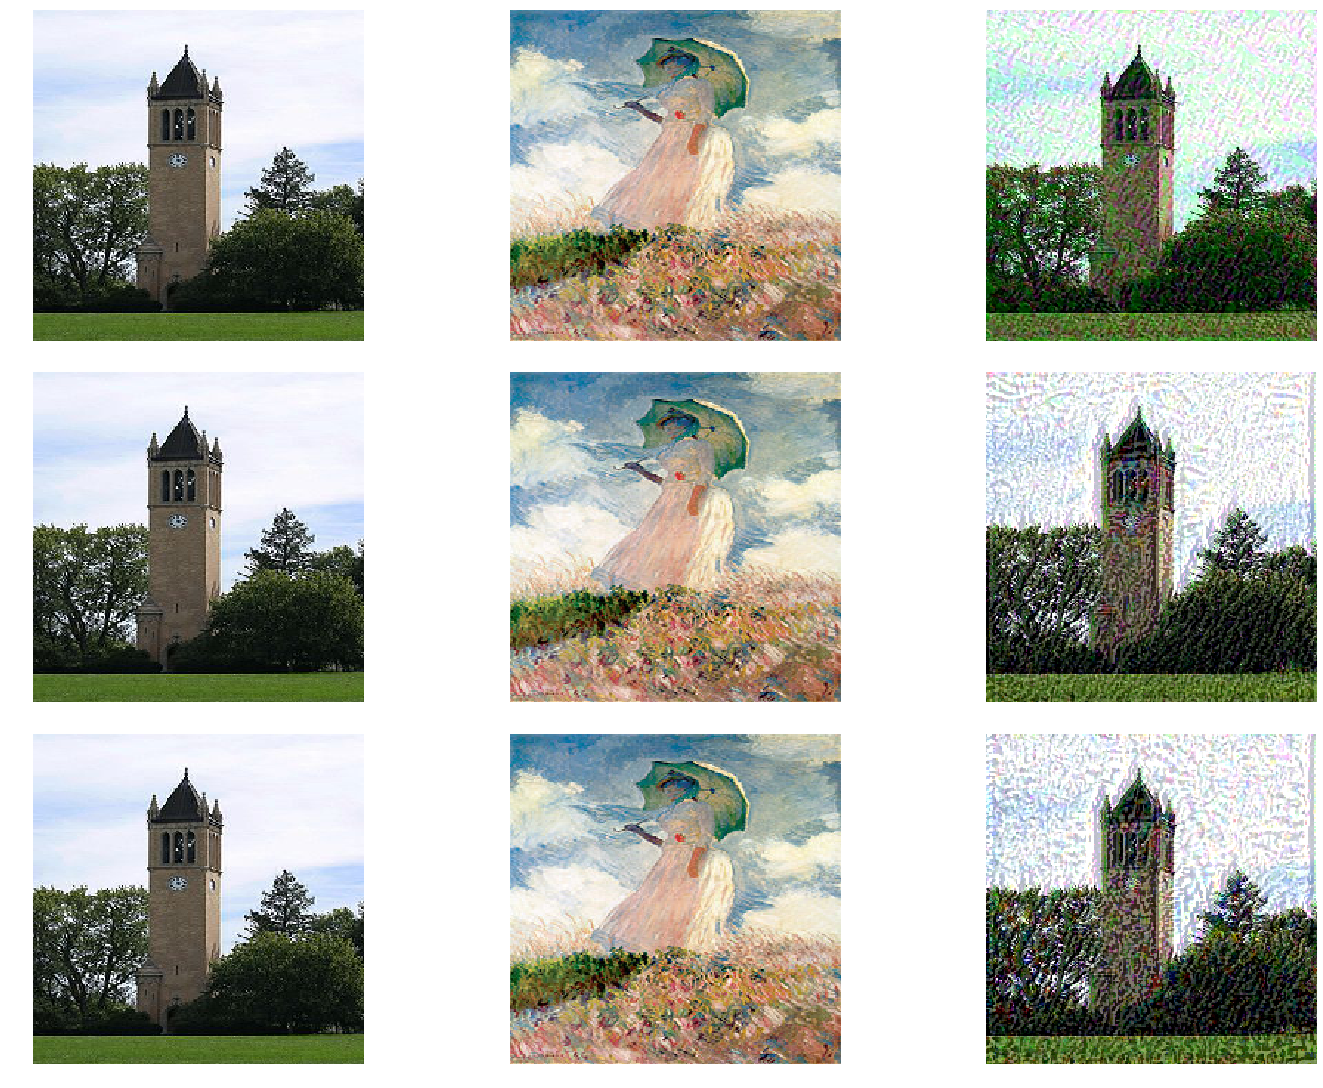

In [195]:
multi_imageComparison('images/campanile.jpg', 'images/monet_style.jpg',
                      trial0, trial1, trial2, save = True)

I've taken the liberty of compiling the best three style transfer outputs I've obtained through my experimentation, each having small differentiations in paint spots and strokes from the style image.

A problem with these images is resolution. During their rescaling, they've become even more pixelated than their originals (both input and style image are under 35 Kb). This could explain why the output images are so pixelated.

This concludes the end of this notebook. Part of this code will be exported and used to train other images and styles, producing interesting and hopefully accurate outputs.